In [14]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import time

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Define the transformations

In [2]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





## Create data loaders to shuffle and create batches

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [4]:
print('No. of train images: {}'.format(len(trainset)))
print('No. of test images: {}'.format(len(testset)))

print('No. of train batches: {}'.format(len(trainloader)))
print('No. of test batches: {}'.format(len(testloader)))

No. of train images: 60000
No. of test images: 10000
No. of train batches: 60
No. of test batches: 100


## Create the Network

In [5]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(12 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.reshape(-1, 12 * 4 * 4)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        return x

# create an instance of the Network    
network = Network()

# move the network object to GPU
network.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)

## Function to find the accuracy

In [0]:
def find_acc(pred, label):
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item()
    return accuracy

## Train the Network

In [0]:
num_epochs = 250

# loss defined using torch.nn
loss = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# note the starting time to find the total time elapsed
start_time = time.time()

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    acc_train = 0
    acc_valid = 0
    
    # set the network into train mode
    network.train()
    
    for step in range(len(trainloader)):

        images , labels = next(iter(trainloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = loss(pred , labels)
        
        # find accuracy
        acc_train_step = find_acc(pred, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()

        acc_train += acc_train_step  
        
    network.eval()    
        
    for step in range(len(testloader)):

        images , labels = next(iter(testloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_valid_step = loss(pred , labels)
        
        # find accuracy
        acc_valid_step = find_acc(pred, labels)
      
        loss_valid += loss_valid_step.item()
    
        acc_valid += acc_valid_step
    
    loss_train /= len(trainloader)
    loss_valid /= len(testloader)
   
    acc_train /= len(trainloader)
    acc_valid /= len(testloader)
    
    print('Epoch: {}  Train Loss: {}  Train Acc: {}  Valid Loss: {}  Valid Acc: {}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))
    
# find the time at the end of training    
end_time = time.time()

total_time = end_time - start_time
print("Total time taken : {}".format(total_time))

#Generating optimum input images
###Start with a zeros image as input

In [0]:
optimal_image = torch.zeros((1,1,28,28), requires_grad=True, device="cuda")

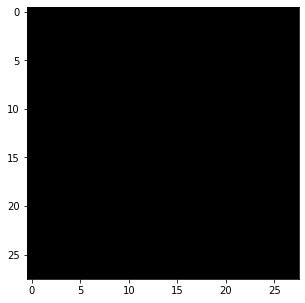

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(optimal_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0).squeeze(-1), cmap = 'gray')

###Update the image to minimise the loss

In [37]:
num_epochs = 5000

# Generating the label (Pytorch cross entropy takes the integer not one hot encoded vectors)
labels = torch.tensor([0]).cuda()

# loss defined using torch.nn
criterion = nn.CrossEntropyLoss()

# define the optimizer
# only the input image has to be updated
gen_optimizer = optim.Adam([optimal_image], lr=0.001)

# note the starting time to find the total time elapsed
start_time = time.time()

for epoch in range(1,num_epochs+1):
    
    loss_gen = 0
    
    # set the network into train mode
    network.eval()
     
    logits = network(optimal_image)
    
    # clear all the gradients before calculating them
    gen_optimizer.zero_grad()
    
    # find the loss and acc for the current step
    loss_gen_step = criterion(logits, labels)
    
    # calculate the gradients
    loss_gen_step.backward()
    
    # update the parameters
    gen_optimizer.step()
    
    loss_gen += loss_gen_step.item()
    
    print('Epoch: {}  Generation Loss: {:.4f}'.format(epoch, loss_gen))

# find the time at the end of training    
end_time = time.time()

print('Generation Complete')
print("Total time taken : {} s".format(end_time - start_time))

Streaming output truncated to the last 5000 lines.
Epoch: 4  Generation Loss: 12.8280
Epoch: 5  Generation Loss: 12.7435
Epoch: 6  Generation Loss: 12.6590
Epoch: 7  Generation Loss: 12.5741
Epoch: 8  Generation Loss: 12.4893
Epoch: 9  Generation Loss: 12.4043
Epoch: 10  Generation Loss: 12.3192
Epoch: 11  Generation Loss: 12.2340
Epoch: 12  Generation Loss: 12.1489
Epoch: 13  Generation Loss: 12.0640
Epoch: 14  Generation Loss: 11.9737
Epoch: 15  Generation Loss: 11.8829
Epoch: 16  Generation Loss: 11.7914
Epoch: 17  Generation Loss: 11.6992
Epoch: 18  Generation Loss: 11.6068
Epoch: 19  Generation Loss: 11.5138
Epoch: 20  Generation Loss: 11.4207
Epoch: 21  Generation Loss: 11.3271
Epoch: 22  Generation Loss: 11.2330
Epoch: 23  Generation Loss: 11.1386
Epoch: 24  Generation Loss: 11.0439
Epoch: 25  Generation Loss: 10.9487
Epoch: 26  Generation Loss: 10.8531
Epoch: 27  Generation Loss: 10.7579
Epoch: 28  Generation Loss: 10.6626
Epoch: 29  Generation Loss: 10.5674
Epoch: 30  Generati

###Optimal Input Image

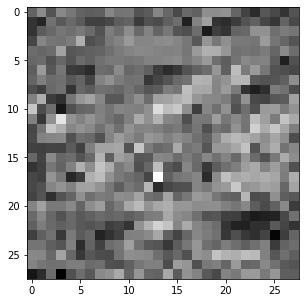

In [38]:
plt.figure(figsize=(5,5))
plt.imshow(optimal_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0).squeeze(-1), cmap = 'gray')